In [48]:
from langchain_core.messages import SystemMessage, ToolMessage, AIMessage, HumanMessage
from langchain_mistralai import ChatMistralAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
import os
import uuid
from typing import Dict

from dotenv import load_dotenv
load_dotenv()

# Configure Mistral API Key
os.environ['MISTRAL_API_KEY'] = os.getenv('MISTRAL_API_KEY')

# LLM Configuration
llm = ChatMistralAI(
    model="mistral-small-latest",
    temperature=0,
    max_retries=3
)

# # Prompts
# sys_prompt = "You are a helpful assistant that translates English to Spanish"
# hum_prompt = "Translate the user sentence without giving more details just the translation: I love programming."

# # Invoke LLM
# response = llm.invoke([
#     SystemMessage(content=sys_prompt),
#     HumanMessage(content=hum_prompt)]
# ).content.strip()

# print(response)

'Me encanta programar.'

In [11]:
# State definition
class State(TypedDict):
    messages: Dict

In [12]:
# Define functions for processing
def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

In [40]:
def get_cv_content(state):
    print("***** get_cv_content *****")

    cv_path = state['messages']['cv_path']
    cv_content = read_file(cv_path)

    tool_call = ToolMessage(
        content=cv_content,
        tool_call_id=str(uuid.uuid4())
    )
    new_state = {
        "messages": {
            "job_path": state['messages']['job_path'],
            "cv_content": tool_call
        }
    }
    return new_state

def get_job_description(state):
    print("***** get_job_description *****")

    job_path = state['messages']['job_path']
    job_content = read_file(job_path)

    tool_call = ToolMessage(
        content=job_content,
        tool_call_id=str(uuid.uuid4())
    )
    new_state = {
        "messages": {
            "cv_content": state['messages']['cv_content'],
            "job_content": tool_call
        }
    }
    return new_state

def evaluate_match(state):
    print("***** evaluate_match *****")

    cv_content = state["messages"]["cv_content"].content
    job_description = state["messages"]["job_content"].content

    hum_evaluation_template = """CV:
    {cv}
    ===
    Job Description:
    {job}
    ===
    Evaluate whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific reasons for your assessment, ensuring a detailed and professional response:
    """
    hum_evaluation_prompt = hum_evaluation_template.format(cv=cv_content, job=job_description)
    sys_evaluation_prompt = """You are tasked with evaluating whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific, detailed reasons for your assessment."""

    # Ensure that only the text content is passed to the AIMessage
    response = llm.invoke([SystemMessage(content=sys_evaluation_prompt), HumanMessage(content=hum_evaluation_prompt)])
    content = response.content.strip()
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    new_state = {
        "messages": {
            "evaluation": ai_call
        }
    }
    return new_state


def generate_email(state):
    print("***** generate_email *****")

    evaluation_result = state["messages"]["evaluation"].content

    hum_email_template = """Job Application Evaluation:
    {evaluation}
    ===
    Based on the evaluation of the match between the candidate's CV and the job description, draft an email to the candidate communicating the result of the assessment. Clearly indicate whether or not the candidate has been selected for the position and provide the reasons for the decision. Ensure the tone is polite, professional, and respectful, starting the email with a courteous acknowledgment.
    Email:
    """
    hum_email_prompt = hum_email_template.format(evaluation=evaluation_result)
    sys_email_prompt = """You are a hiring manager tasked with drafting an email to a candidate regarding the result of their job application assessment. Clearly communicate whether the candidate has been selected for the position, and provide reasons for the decision. Maintain a polite, professional, and respectful tone, starting the email with a courteous acknowledgment."""

    response = llm.invoke([SystemMessage(content=sys_email_prompt), HumanMessage(content=hum_email_prompt)])
    content = response.content.strip()
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    new_state = {
        "messages": {
            "email": ai_call
        }
    }

    return new_state

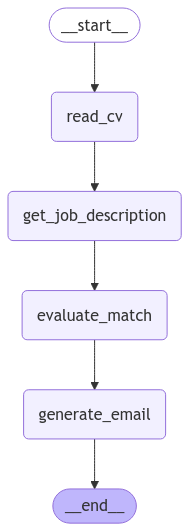

In [41]:
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_node("read_cv", get_cv_content)
workflow.add_node("get_job_description", get_job_description)
workflow.add_node("evaluate_match", evaluate_match)
workflow.add_node("generate_email", generate_email)

workflow.add_edge(START, "read_cv")
workflow.add_edge("read_cv", "get_job_description")
workflow.add_edge("get_job_description", "evaluate_match")
workflow.add_edge("evaluate_match", "generate_email")
workflow.add_edge("generate_email", END)

graph = workflow.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
def main(cv_path, job_path):
    state = {"messages": {"cv_path": cv_path, "job_path": job_path}}

    config = {
        "configurable": {
            "thread_id": str(uuid.uuid4()),
            "checkpoint_ns": "default_ns",
            "checkpoint_id": str(uuid.uuid4()),
        }
    }

    output = None
    for output in graph.stream(state, config=config, stream_mode="updates"):
        print("Current Output:", output)

    return output

In [43]:
cv_path = "data/cv.txt"
job_path = "data/job_description.txt"

output = main(cv_path, job_path)

***** get_cv_content *****
Current Output: {'read_cv': {'messages': {'job_path': 'data/job_description.txt', 'cv_content': ToolMessage(content="Daniel Puente Viejo\n+34 638 097 547\ndaniel.puenteviejo@gmail.com\nCertifications and personal projects\n•\nSelected among the 5 best Bachelor Thesis out of 300 candidates in the Mondragon Corporation Awards.\n•\nSelected as one of around 250 participants in the Bizkaia Talent program “attracting young talents”.\n•\nAzure Certified with more than 30 courses and certifications done in AI (x3 Microsoft Certified)\n•\nScholarship for academic excellence (2019).\nhttps://github.com/DanielPuentee\nhttps://www.linkedin.com/in/danielpuenteviejo\nhttps://medium.com/@daniel.puenteviejo\nhttps://huggingface.co/D0k-tor\nPROFESSIONAL EXPERIENCE\nNTT Data\n➢\nClients: Cepsa, Repsol, Unsere Grüne Glasfaser, RED.es, BBVA, NTT Data (Intern client)\nExternal Senior AI Engineer at Repsol; Bilbao, Spain 10/2024 - Present\n•\nLed the design of Repsol's cross AI M

In [44]:
print(output['generate_email']['messages']['email'].content)

Subject: Result of Your Application for the Research Internship at Microsoft's Gray Systems Lab

Dear Daniel Puente Viejo,

I hope this email finds you well. I am writing to update you on the status of your application for the Research Internship at Microsoft's Gray Systems Lab.

We have thoroughly reviewed your CV and are pleased to inform you that your application has been highly regarded. Your educational background, particularly your Master of Science in Artificial Intelligence from UNIR, aligns exceptionally well with the requirements of our program. Your extensive experience in AI engineering roles at NTT Data, coupled with your proficiency in programming languages such as Python, R, and SQL, as well as your experience with AI frameworks and cloud platforms, demonstrates a strong fit for the role.

Additionally, your certifications, academic achievements, and the initiative you have shown in leading projects and developing innovative solutions, such as the AI initiative and vario